In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")

d:\Anaconda\envs\DataScience\lib\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


## Forecast positif harian

In [2]:
data = pd.read_excel(
    "../../data/covid-indo/raw/Daily Update Data Agregat Covid-19 Jakarta.xlsx", sheet_name="Data Jakarta")
positif_harian = data[["Tanggal", "Positif Harian"]]
positif_harian["Tanggal"] = pd.to_datetime(positif_harian["Tanggal"])
positif_harian.set_index("Tanggal", inplace=True)
positif_harian.head()

,Positif Harian
Tanggal,
2020-03-01,0
2020-03-02,0
2020-03-03,3
2020-03-04,0
2020-03-05,4


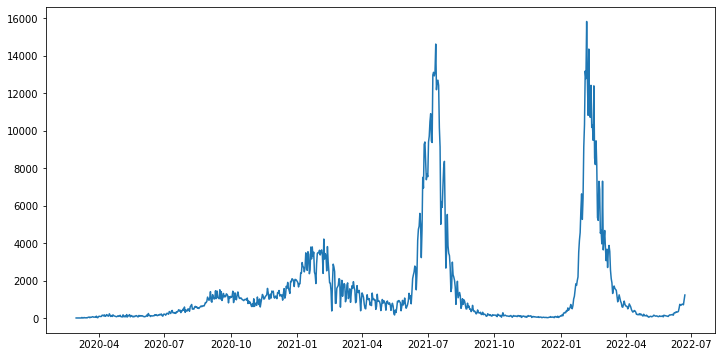

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(positif_harian["Positif Harian"])
plt.show()

ternyata datanya seasonal setiap kurang lebih 6 bulan sekali kayanya

In [4]:
def adfuller_test(df):
    result = adfuller(df)
    print("ADF Statistic: %f" % result[0])
    print("p-value: %f" % result[1])
    if result[1] < 0.05:
        print("stationary")
    else:
        print("not stationary")

adfuller_test(positif_harian["Positif Harian"])

ADF Statistic: -4.219197
p-value: 0.000611
stationary


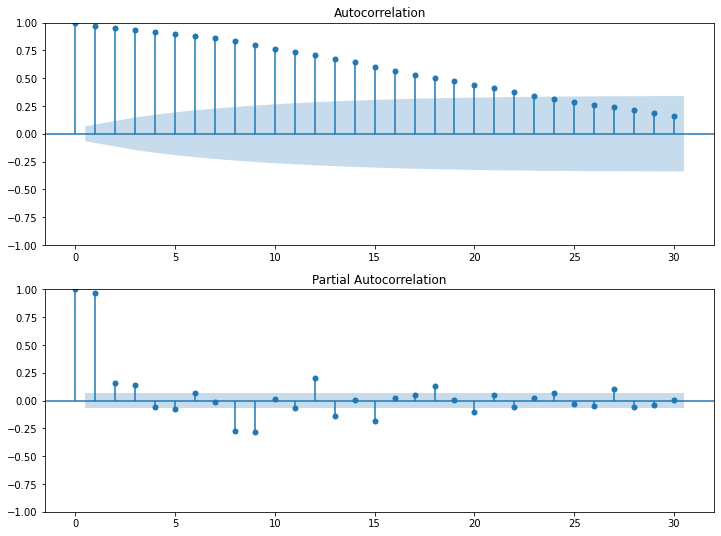

In [5]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
plot_acf(positif_harian["Positif Harian"], ax=ax1)
plot_pacf(positif_harian["Positif Harian"], ax=ax2)
fig.set_size_inches(12, 9)

acf exponential decrease, pacf sudden drop after lag 2. Kayanya cuma perlu AR atau SAR model
\
\
SARIMA(0,0,2,6) -> p = 0 (exponential) ; d = 0 (stationary) ; q = 2 (sudden drop after 2nd lag) ; s = 6 (seasonal pattern) -> ternyata 8

## SARIMA

In [62]:
positif_harian_trim = positif_harian.loc["2021-04":]
len(positif_harian_trim)

448

<AxesSubplot:xlabel='Tanggal'>

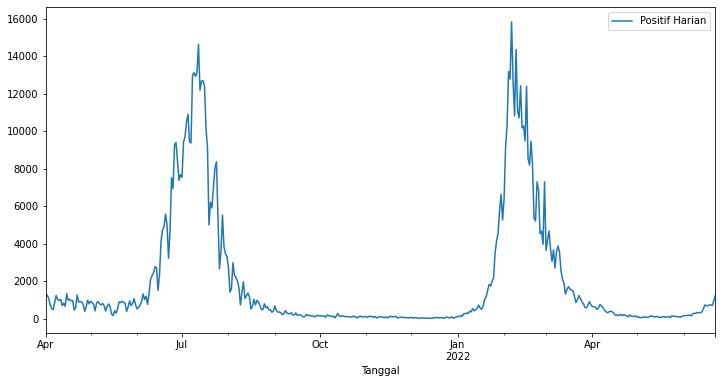

In [63]:
positif_harian_trim.plot(figsize=(12, 6))

Ada seasonal tiap 8 bulan ternyata, karena ini datanya perhari berarti 8 * 30 = 240

In [76]:
model = sm.tsa.statespace.SARIMAX(
    positif_harian_trim["Positif Harian"], order=(0, 0, 2), seasonal_order=(0, 0, 2, 240))
results=model.fit()

<AxesSubplot:xlabel='Tanggal'>

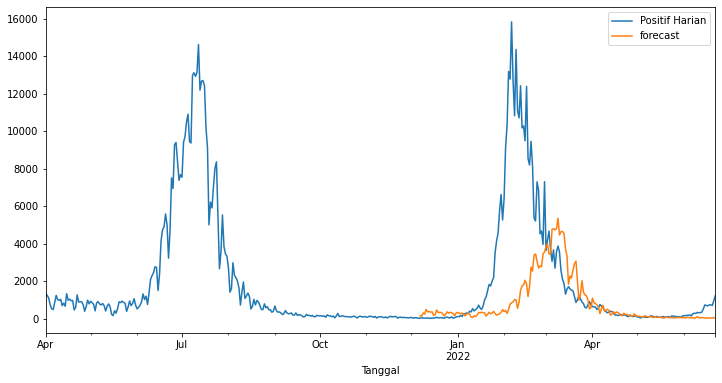

In [87]:
positif_harian_trim["forecast"] = results.predict(
    start=250, dynamic=True)
positif_harian_trim.plot(figsize=(12, 6))

In [96]:
positif_harian_trim

,Positif Harian,forecast
Tanggal,,
2021-04-01,1337,NaN
2021-04-02,1240,NaN
2021-04-03,1098,NaN
2021-04-04,736,NaN
2021-04-05,523,NaN
...,...,...
2022-06-18,733,32.594588
2022-06-19,735,30.397200
2022-06-20,701,42.482834


In [145]:
from pandas.tseries.offsets import DateOffset
future_date = [positif_harian_trim.index[-1] + DateOffset(days=x) for x in range(0, 120)] # 4 bulan
future_date_df = pd.DataFrame(index=future_date[1:],columns=positif_harian_trim.columns)
future_date_df_merge = pd.concat([positif_harian_trim, future_date_df])
future_date_df_merge

,Positif Harian,forecast
2021-04-01,1337,NaN
2021-04-02,1240,NaN
2021-04-03,1098,NaN
2021-04-04,736,NaN
2021-04-05,523,NaN
...,...,...
2022-10-15,NaN,NaN
2022-10-16,NaN,NaN
2022-10-17,NaN,NaN
2022-10-18,NaN,NaN


<AxesSubplot:>

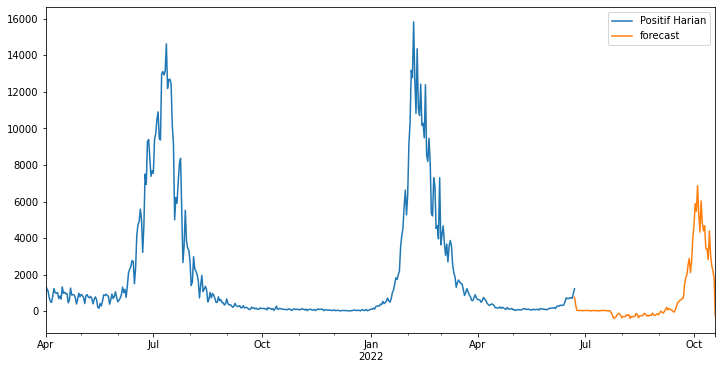

In [146]:
future_date_df_merge["forecast"] = results.predict(
    start=447, end=807, dynamic=True)
future_date_df_merge.plot(figsize=(12, 6))

## Evaluation

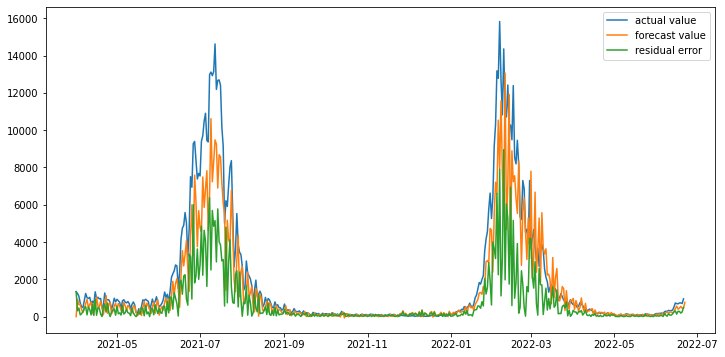

{'mae': 722.021821212612, 'rmse': 1527.6322395926181}

In [162]:
def forecast_accuracy(forecast, actual):
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mae': mae, 
            'rmse':rmse})

actual_value = positif_harian_trim["Positif Harian"][:447]
forecast_value = results.predict(start=0, end=447, dynamic=False)

plt.figure(figsize=(12, 6))
plt.plot(actual_value, label="actual value")
plt.plot(forecast_value, label="forecast value")
plt.plot(abs(forecast_value - actual_value), label="residual error")
plt.legend()
plt.show()

forecast_accuracy(forecast_value, actual_value)